# Gaussian process regression

In this notebook, we are going to implement Gaussian process regression with Tensorflow Probability, which is probabilistic framework built on top of Tensorflow. In addition to automatic differentiation provided by tensorflow, we can easily define probability distributions on variables (and tensors) and connect these variables by functional relationships.

First we load all the required packages:

In [1]:
import matplotlib.pyplot as plt  # for plotting
import numpy as np  # for doing linear algebra stuff
import tensorflow as tf  # for doing linear algebra stuff
import tensorflow_probability as tfp
tfd = tfp.distributions

2023-05-25 16:30:15.934571: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-25 16:30:15.936202: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 16:30:15.966933: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-25 16:30:15.967633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 16:30:16.402576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Preliminaries

With Tensorflow, we can define constants and variables. Constants cannot be changed whereas variables can. They can be defined in the following way:

In [2]:
a = tf.constant([1, 2, 3], dtype=tf.float64)
x = tf.Variable([4, 5, 6], dtype=tf.float64)

To avoid cumbersome bugs, it is helpful to be always explicit about the data types by providing the *dtype* argument. Otherwise types will be inferred from the provided list.

Inputs can be linked together transformed and linked together. For instance,

In [3]:
r = tf.add(a, x) # alternatively: r = a + x
u = tf.math.square(r)
u

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([25., 49., 81.])>

Reshaping tensors is helpful to bring them to appropriate shape required for an operation. For instance, to convert a one-dimensional tensor to a column vector:

In [4]:
a = tf.reshape(x, (-1, 1))
a

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[4.],
       [5.],
       [6.]])>

The specification of *-1* signifies that tensorflow figures out the appropriate number for that dimension based on the total size of the tensor and the other dimension specifications.

To reshape a tensor to obtain a row vector, we can write:

In [5]:
b = tf.reshape(x, (1, -1))
b

<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[4., 5., 6.]])>

*Broadcasting* is a useful mechanism to apply mathematical operations on tensor of different shapes. For instance, an element-wise multiplication of a 1x3 tensor with a 3x1 tensor will yield a 3x3 tensor. For instance consider the multiplication of the tensors `a` and `b` above:

In [6]:
a * b

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[16., 20., 24.],
       [20., 25., 30.],
       [24., 30., 36.]])>

# Activities

A) First we will create functions that will help us to construct the prior distribution, which is a multivariate normal distribution that represents the discretized version of a Gaussian process on a given mesh of x-values. This will involve the following tasks:

1) Implementation of a covariance function to calculate a covariance matrix for specified mesh of x-values
2) Implementation of a function that creates an instance representing a multivariate normal distribution (part of Tensorflow Probability)
3) Then we will use this function to write a function to evaluate the logarithmized probability density function (logpdf) for a given input vector. We refer to this as *prior logpdf*.

B) Afterwards, we want to use some observations to constrain the Gaussian process. We are going to implement this in the following way:

1) As we have defined the Gaussian process on a discrete mesh of x-values and the observations lie potentially in-between the mesh points, we will implement linear interpolation to map to the observation points.
2) Afterwards, using the interpolation function, we are going to write a function to create a function that returns the logarithmized likelihood $\rho(y_\text{obs} \,|\, y_\text{mesh})$. This function is the probabilistic link connecting the values at $y_\text{mesh}$ associated with the Gaussian process prior to the observations.
3) Then, we will combine the prior logpdf and the log-likelihood to a joint distribution to obtain the posterior pdf.

C) With the posterior pdf available, we will explore a bit how to find the most likely assignment of y-values on the predefined x-mesh. We are going to see how the Adam optimizer performs and then implement one step of Newton method.

## Task group (A)

### A.1) Implementation of the covariance function:

$\kappa(x, x') = \delta^2 \exp\left(-\frac{1}{2\lambda^2} (x_1 - x_2)^2  \right)$

Complete the following function skeleton. `xmesh` is a one-dim vector containing the discretized mesh of x-values for the Gaussian process, `amp` is $\delta$, `lscl` is $\lambda$. For numerical stability, a small value is added to the diagonal elements, which is often called a `nugget` parameter.

*Hints:*
- you may want to reshape `xmesh` at the beginning to be sure about its shape (`tf.reshape`)
- Other potential useful functions are `tf.transpose`, `tf.math.square`, `tf.math.exp` 
- For debugging, instead of directly completing the function body, you may want to create the functionality in a separate cell line by line to check whether inputs and outputs are according to your expectation. 

In [7]:
def create_covmat_squaredexp(xmesh, amp, lscl, nugget=1e-6):
    xmesh = tf.reshape(xmesh, (-1, 1))
    xmesh_diff = (xmesh - tf.transpose(xmesh)) / lscl
    expo = -0.5 * tf.math.square(xmesh_diff)
    covmat = amp*amp * tf.math.exp(expo)
    covmat = covmat + tf.linalg.diag(
        tf.fill(tf.size(xmesh), tf.constant(nugget, dtype=tf.float64))
    )
    return covmat

Here is a brief check whether your implementation is correct:

In [8]:
testx = tf.constant(np.linspace(0, 10, 10), dtype=tf.float64)
testcov = create_covmat_squaredexp(testx, 5, 2, nugget=1e-6)
testcov[0:3, 1]
# <tf.Tensor: shape=(3,), dtype=float64, numpy=array([21.42492229, 25.000001  , 21.42492229])>

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([21.42492229, 25.000001  , 21.42492229])>

### A.2) Implementation of prior distribution

Now we create a function that should return an object that represents the prior distribution. More precisely, the function should take a covariance matrix and a mean vector and return an instance of `MultivariateNormalTriL`.

*Hints:*
- In order to produce an instance of `MultivariateNormalTriL`, we need to provide the mean vector as `loc` argument and a Cholesky decomposition of the covariance matrix as argument `scale_tril`.
- The function `tf.linalg.cholesky` can be used to compute the Cholesky decomposition. 

In [9]:
def create_prior_prob(mu, covmat):
    scale = tf.linalg.cholesky(covmat)
    mvn = tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale)
    return mvn


Let's test the function by using it to create a distribution object and draw samples from it:

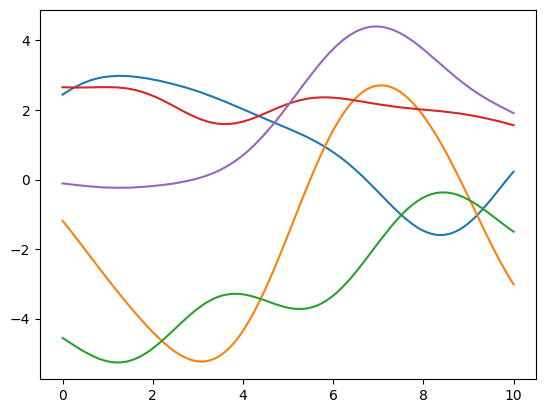

In [10]:
def plot_samples(n, prob): 
    smpl = prob.sample(n)
    for i in range(smpl.shape[0]):
        plt.plot(xin, smpl[i, :]) 
    plt.show()

# sample from distribution
xin = tf.linspace(0, 10, 100) 
mu = tf.zeros(xin.shape, dtype=tf.float64) 
covmat_sqrexp = create_covmat_squaredexp(xin, 2, 2.)
prior_prob_sqrexp = create_prior_prob(mu, covmat_sqrexp)
plot_samples(5, prior_prob_sqrexp)

### A.3) Implementatin of function to evaluate logarithmized prior pdf

Tensorflow probability distribution objects provide the `.log_prob` method. The only thing we need to do is to create a new variable that references this method.

In [11]:
prior_logpdf = None # replace None by something here using the prior_prob_sqrexp variable defined above

## Task group (B)

### B.3: Implementation of linear interpolation

In order to obtain predictions at the x-values of the experimental data, we want to use linear interpolation to go from the predefined mesh associated with the Gaussian process to the x-values of the data. The argument `xin` represents the x-mesh associated with the Gaussian process and `yin` the y-values for this mesh. `xout` contains the x-values of interest, i.e., where we have the observations.

*Hints:*
- You can assume that `xin` is already sorted
- The function `tf.searchsorted` is helpful to find into which intervals in `xin` the x-values in `xout` fall.
- `tf.gather`, will be helpful to obtain a reduced tensor that is obtained from the original tensor by picking only the values at specific indices.
- Once every interval is obtained, you can calculate the `intercept` and `slope` for each interval and use that to calculate the result of the linear interpolation. 

In [12]:
def interpolate(xin, yin, xout):
    idcs = tf.searchsorted(xin, xout, side='left')
    x0 = tf.gather(xin, idcs, axis=-1)
    x1 = tf.gather(xin, idcs + 1, axis=-1)
    y0 = tf.gather(yin, idcs, axis=-1)
    y1 = tf.gather(yin, idcs + 1, axis=-1)
    slopes = (y1 - y0) / (x1 - x0)
    yint = y0 + slopes * (xout-x0)
    return yint

### B.4: Function to return logarithmized likelihood

First, let us create some synthetic observations:

In [13]:
x_exp = tf.constant([3, 5], dtype=tf.float64) 
y_exp = tf.constant([1, 2], dtype=tf.float64)
uncs_exp = tf.constant([0.5, 0.9], dtype=tf.float64)

We can plot the Gaussian process prior together with the experimentla data:

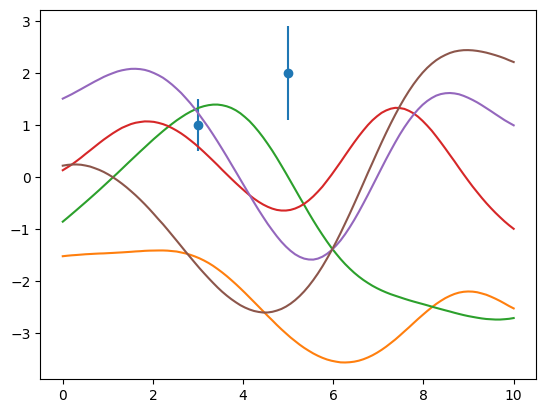

In [14]:
def plot_experimental_data():
    plt.errorbar(x_exp, y_exp, uncs_exp, fmt='o') 

plot_experimental_data()
plot_samples(5, prior_prob_sqrexp)

In order to make use of these observations, we want to implement a function that creates a function to evaluate the logarithmied likelihood. You only have to complete the inner function definition. First, we need to obtain based on `yin` on the Gaussian process mesh the predicted values `ymod` at the x-values of the experiment `x_exp`. Finally, we want to create a multivariate normal distribution (`MultivariateNormalDiag`) with a mean vector given by `ymod` and a diagonal covariance matrix with the diagonal elements given by the squared elements in `uncs_exp`.


In [15]:
def create_likelihood_logpdf(x_exp, y_exp, uncs_exp, xin):
    def fun(yin):
        ymod = interpolate(xin, yin, x_exp)
        mvn = tfd.MultivariateNormalDiag(loc=ymod, scale_diag=tf.math.square(uncs_exp))
        return mvn.log_prob(y_exp)
    return fun

Now we can use this function to define the likelihood.

In [16]:
like_logpdf = create_likelihood_logpdf(x_exp, y_exp, uncs_exp, xin)

We can check if the function works as expected:

In [17]:
np.random.seed(23)
yin_test = tf.constant(np.random.normal(size=xin.shape), dtype=tf.float64)
like_logpdf(yin_test)
# expected: <tf.Tensor: shape=(), dtype=float64, numpy=-8.140256650466686>

<tf.Tensor: shape=(), dtype=float64, numpy=-8.140256650466686>

### B.3 Log posterior pdf

Almost done! We now implement a function that returns a function to evaluate the logarithmic posterior distribution. The inner function needs to evaluate the sum of `prior_logpdf` and `like_logpdf` for the passed value `yin`.

In [18]:
def create_post_logpdf(prior_logpdf, like_logpdf):
    # @tf.function
    def fun(yin):
        return prior_logpdf(yin) + like_logpdf(yin)
    return fun

Finally, we can create the function representing the logarithmized posterior pdf.

In [19]:
post_logpdf = create_post_logpdf(prior_prob_sqrexp.log_prob, like_logpdf)

## Task group (C)

We can use optimization to find the most likely values of `yin` that are most compatible with the experimental data. The routines are already provided here. Feel free to try different optimizers or dabble with the observations or Gaussian process prior to see how the posterior predictions change.

First, we use the stochastic Adam optimizer and see what we get:

In [20]:
def adam_maximizer(x, fun, iters=100, learning_rate=1):
    def negfun(x):
        return -fun(x)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for i in range(iters):
        with tf.GradientTape() as tape:
            y = negfun(x)
        gradients = tape.gradient(y, [x])
        optimizer.apply_gradients(zip(gradients, [x]))
    return x

Here we study a bit how the Adam optimizer performs. Feel free to adjust parameters:

tf.Tensor(-400.6831599900971, shape=(), dtype=float64)


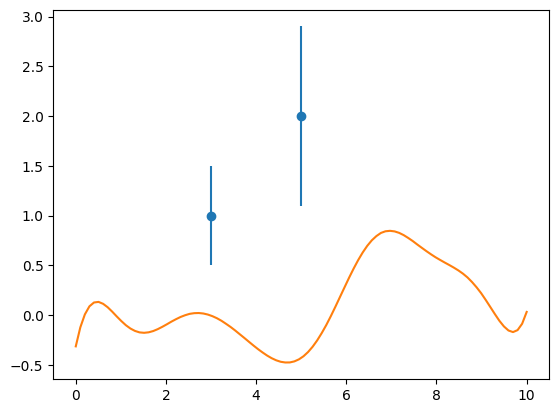

In [21]:
yopt = tf.Variable(yin_test)
post_logpdf(yopt)
adam_maximizer(yopt, post_logpdf, iters=200, learning_rate=0.1)
print(post_logpdf(yopt))
# plot the solution
plot_experimental_data()
plt.plot(xin, yopt)
plt.show()

In comparison, the following implements the Newton-method to find the root of the first derivative (which means the maximum of the log postpdf)

In [22]:
def bfgs_update(x, logpdf):
    with tf.GradientTape() as t2:
        t2.watch(x)
        with tf.GradientTape() as t1:
            t1.watch(x)
            y = logpdf(x)
        grad_post_logpdf = t1.gradient(y, x)
    hessian = t2.jacobian(grad_post_logpdf, x) 
    # find most likely assignment of parameters
    xopt = x - tf.squeeze(tf.linalg.inv(hessian) @ tf.reshape(grad_post_logpdf, (-1, 1)))
    # yopt_ref = yin_test - tf.squeeze(tf.linalg.solve(hessian, tf.reshape(grad_post_logpdf, (-1, 1))))
    return xopt

tf.Tensor(516.5020464895005, shape=(), dtype=float64)


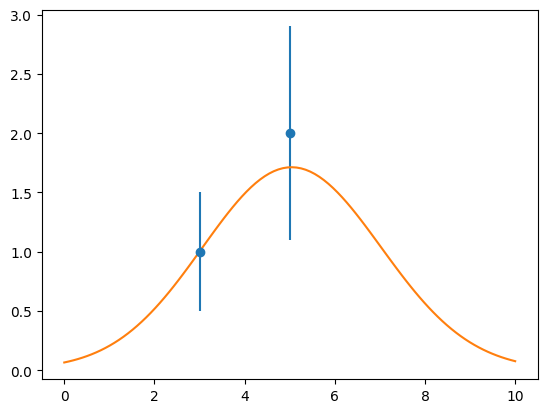

In [23]:
yopt = bfgs_update(yin_test, post_logpdf)
print(post_logpdf(yopt))

plot_experimental_data()
plt.plot(xin, yopt)
plt.show()